## Portfolio Comparison Overview

#### This notebook compares multiple portfolio strategies:
 - Benchmark Portfolio: Buys and holds 1000 shares of each stock.
 - Indicator Strategy: Trained on technical indicators.
 - Sentiment Strategy: Trained on earnings call sentiment features.

#### Assumptions and Constraints
- No Transaction Costs: The portfolio value simulation does not include commissions or market impact.
- Positioning: Each portfolio can hold one of three positions per stock on any given day. (1000: Long position (buy), 0: Neutral (no position), -1000: Short position (sell))

Each strategy's trades are simulated and converted into daily portfolio values for performance comparison

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [332]:
df_prices = pd.read_csv('../data/prices.csv', parse_dates=['date'])
df_prices = df_prices.pivot(index='date', columns='ticker', values='close').sort_index()
price_matrix = df_prices[df_prices.index >= '2018-06-01']

#### Portfolio Value Computation

This function simulates portfolio value over time based on a trades DataFrame
- Initializes holdings and cash on day 0
- Iteratively updates holdings and cash based on daily trades
- Computes total portfolio value as the sum of cash and the market value of holdings

Returns a time series of daily portfolio values.

In [333]:
def compute_portval(trades, prices, start_val=10000):
    trades = trades.reindex(prices.index).fillna(0)
    holdings = pd.DataFrame(0, index=prices.index, columns=prices.columns)
    cash = pd.Series(0.0, index=prices.index)
    cash.iloc[0] = start_val - (trades.iloc[0] * prices.iloc[0]).sum()
    holdings.iloc[0] = trades.iloc[0]

    for i in range(1, len(prices)):
        holdings.iloc[i] = holdings.iloc[i - 1] + trades.iloc[i]
        trade_value = (trades.iloc[i] * prices.iloc[i]).sum()
        cash.iloc[i] = cash.iloc[i - 1] - trade_value

    portvals = (holdings * prices).sum(axis=1) + cash
    return portvals

#### Benchmark Portfolio
Simulates a simple buy-and-hold benchmark strategy. On the first day, the strategy buys 1000 shares of each stock and holds the position throughout the entire period. This provides a baseline for evaluating other strategies.

In [334]:
trades_benchmark = pd.DataFrame(0, index=price_matrix.index, columns=price_matrix.columns)
trades_benchmark.iloc[0] = 1000 
benchmark_vals = compute_portval(trades_benchmark, price_matrix)

#### Indicator Strategy Portfolio
Loads the trade decisions (positions of 1000, 0, or -1000) generated by the indicator strategy model and computes portfolio values.

In [335]:
df_trades = pd.read_csv('../data/indicator_strategy.csv', parse_dates=['date'])
df_trades.set_index('date', inplace=True)
ind_vals = compute_portval(df_trades, price_matrix)

#### Sentiment Strategy Portfolio
Loads the trade decisions (positions of 1000, 0, or -1000) generated by the sentiment strategy model and computes portfolio values.

In [336]:
df_sentiment_trades = pd.read_csv('../data/sentiment_strategy.csv', parse_dates=['date'])
df_sentiment_trades.set_index('date', inplace=True)
sent_vals = compute_portval(df_sentiment_trades, price_matrix)

#### Strategy Comparison
Plot of normalized portfolio value of benchmark, quantitative strategy, and sentiment strategy on the same chart to compare their relative performance from a common starting point.

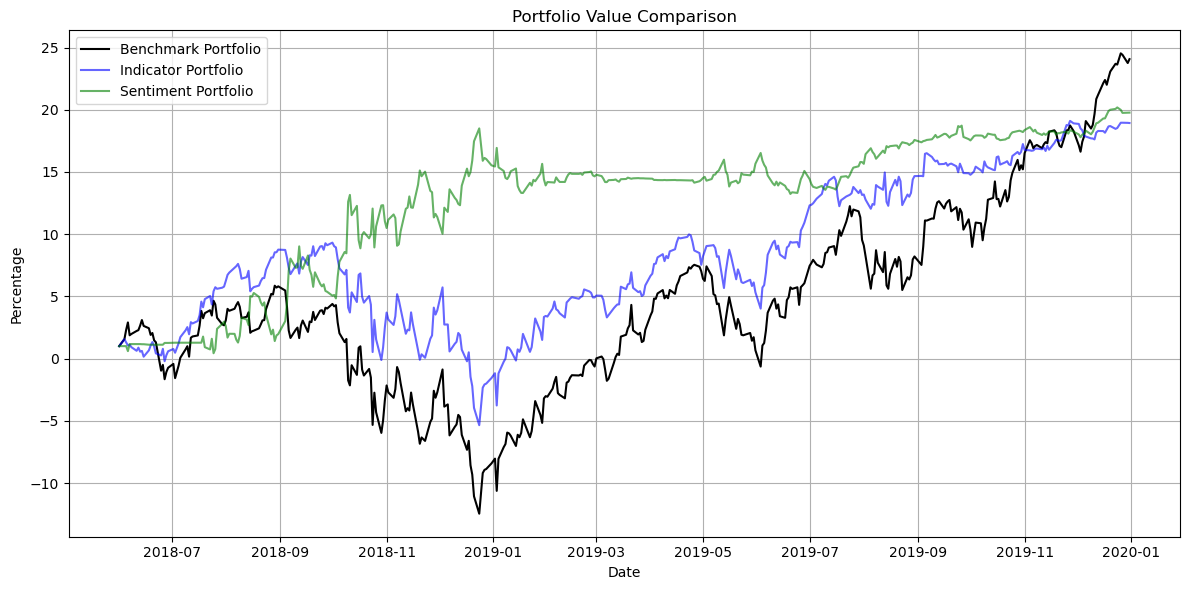

In [345]:
benchmark_norm = (benchmark_vals / benchmark_vals.iloc[0] )
ind_norm = (ind_vals / ind_vals.iloc[0] ) 
sent_norm = (sent_vals / sent_vals.iloc[0] )

plt.figure(figsize=(12, 6))
plt.plot(benchmark_norm, label='Benchmark Portfolio', color = 'black')
plt.plot(ind_norm, label = "Indicator Portfolio", color = 'blue', alpha = 0.6)
plt.plot(sent_norm, label = "Sentiment Portfolio", color = 'green', alpha = 0.6)
plt.title('Portfolio Value Comparison')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Drawdown Analysis

Visualization of the drawdowns of each portfolio, showing how much each strategy declined from its historical peak before recovering.

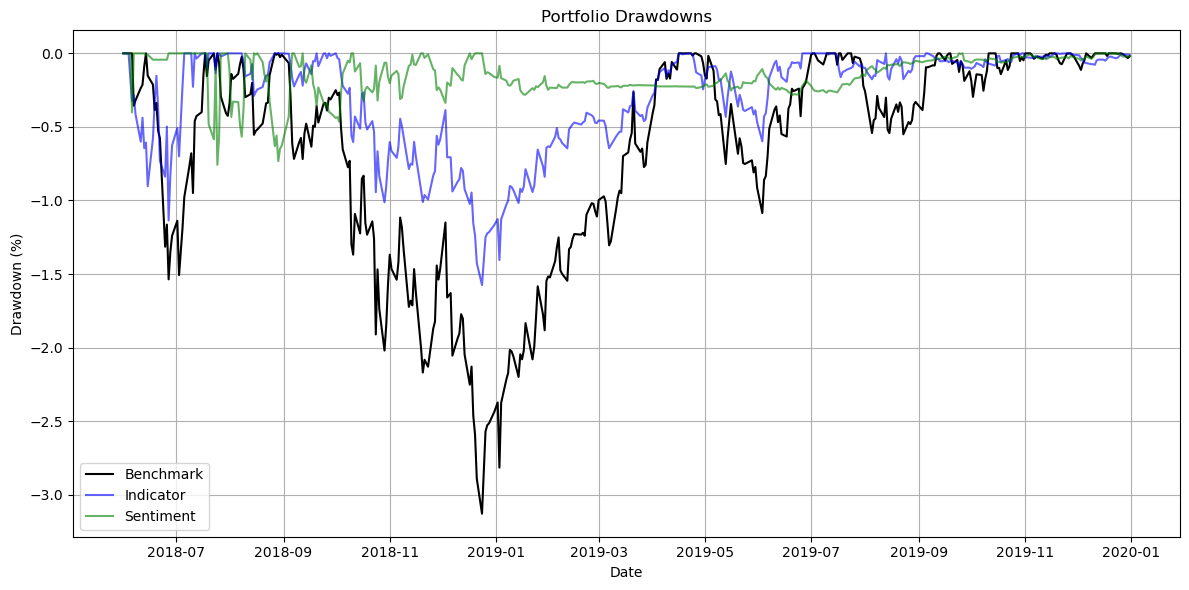

In [348]:
def compute_drawdown(portvals):
    rolling_max = portvals.cummax()
    drawdown = (portvals - rolling_max) / rolling_max
    return drawdown

plt.figure(figsize=(12, 6))
for label, series, color, alpha in [('Benchmark', benchmark_vals, 'black', 1), ('Indicator', ind_vals, 'blue', 0.6), ('Sentiment', sent_vals, 'green', 0.6)]:
    drawdown = compute_drawdown(series)
    plt.plot(drawdown, label=f'{label}', color = color, alpha = alpha)

plt.title("Portfolio Drawdowns")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Portfolio Metrics
Performance indicators for each strategy (cumulative return, daily volatility, Sharpe ratio, and maximum drawdown)

In [364]:
def evaluate_metrics(portvals):
    daily_returns = portvals.pct_change().dropna().clip(lower=-0.2, upper=0.2)
    return {
        'Final Return (%)': ((portvals.iloc[-1] / portvals.iloc[0]) - 1),
        'Volatility (%)': daily_returns.std() * 100,
        'Sharpe Ratio': (daily_returns.mean() / daily_returns.std()) * np.sqrt(252),
        'Max Drawdown (%)': abs(compute_drawdown(portvals).min())
    }

metrics_df = pd.DataFrame({
    'Benchmark': evaluate_metrics(benchmark_vals),
    'Indicator': evaluate_metrics(ind_vals),
    'Sentiment': evaluate_metrics(sent_vals)
}).T.round(2)

print(metrics_df)


           Final Return (%)  Volatility (%)  Sharpe Ratio  Max Drawdown (%)
Benchmark             23.07           13.61          1.03              3.13
Indicator             17.93           11.21          0.24              1.57
Sentiment             18.77            7.21          1.14              0.76


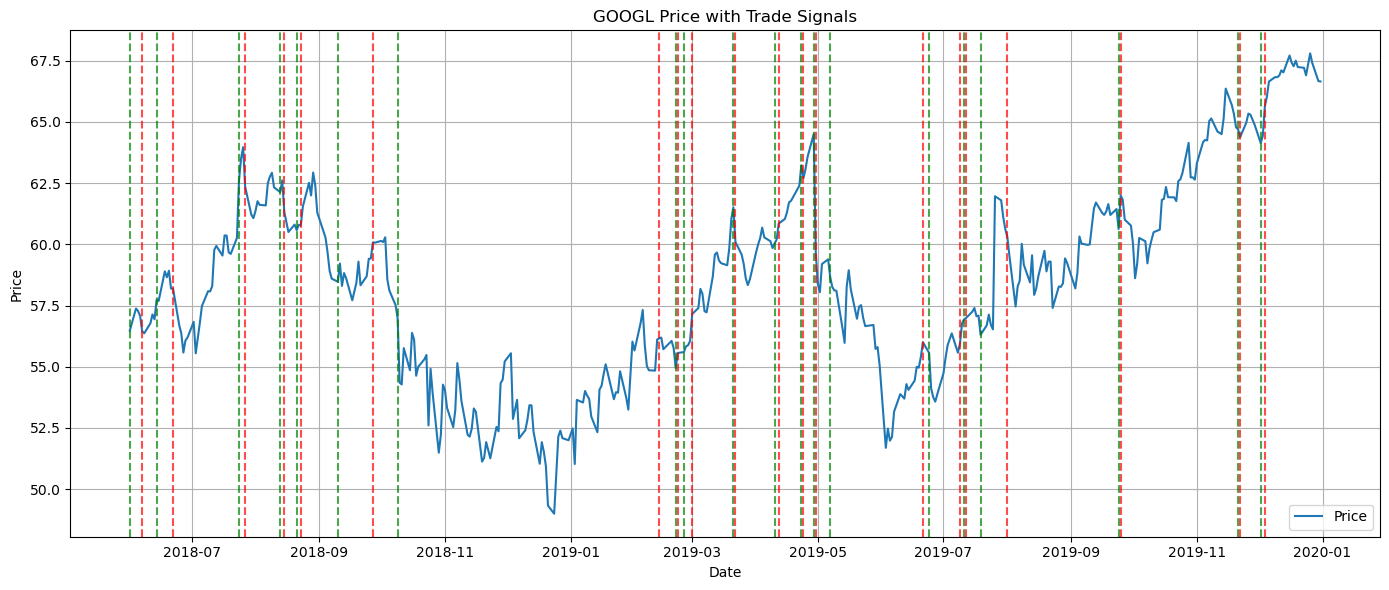

In [320]:
ticker = 'GOOGL'
trade_series = df_trades[ticker]
price_series = price_matrix[ticker]

# Filter non-zero trades
nonzero_trades = trade_series[trade_series != 0]
# Plot with dotted lines at trade points
plt.figure(figsize=(14, 6))
plt.plot(price_series, label='Price')

for trade_date, trade_val in nonzero_trades.items():
    color = 'green' if trade_val > 0 else 'red'
    plt.axvline(x=trade_date, color=color, linestyle='--', alpha=0.7)

plt.title(f'{ticker} Price with Trade Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [374]:
def plot_all_trade_signals_grid(df_trades, price_matrix, strategy):
    tickers = df_trades.columns.tolist()
    
    fig, axes = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        trade_series = df_trades[ticker]
        price_series = price_matrix[ticker]
        nonzero_trades = trade_series[trade_series != 0]

        ax.plot(price_series, label='Price')
        for trade_date, trade_val in nonzero_trades.items():
            color = 'green' if trade_val > 0 else 'red'
            ax.axvline(x=trade_date, color=color, linestyle='--', alpha=0.6)

        ax.set_title(f'{ticker} Price with Trade Signals: ' + f'{strategy} Strategy')
        ax.set_ylabel('Price')
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


### Trade Signal Visualization for Each Ticker
The following grid of plots visualizes trade activity over time for each stock in the portfolio. For each ticker, the historical price is shown as a line, and vertical dashed lines indicate trade signals.

- Green lines represent buy signals (long position entered or increased)
- Red lines represent sell signals (short position entered or increased)

This visualization helps assess the timing and frequency of trades generated by the strategy.

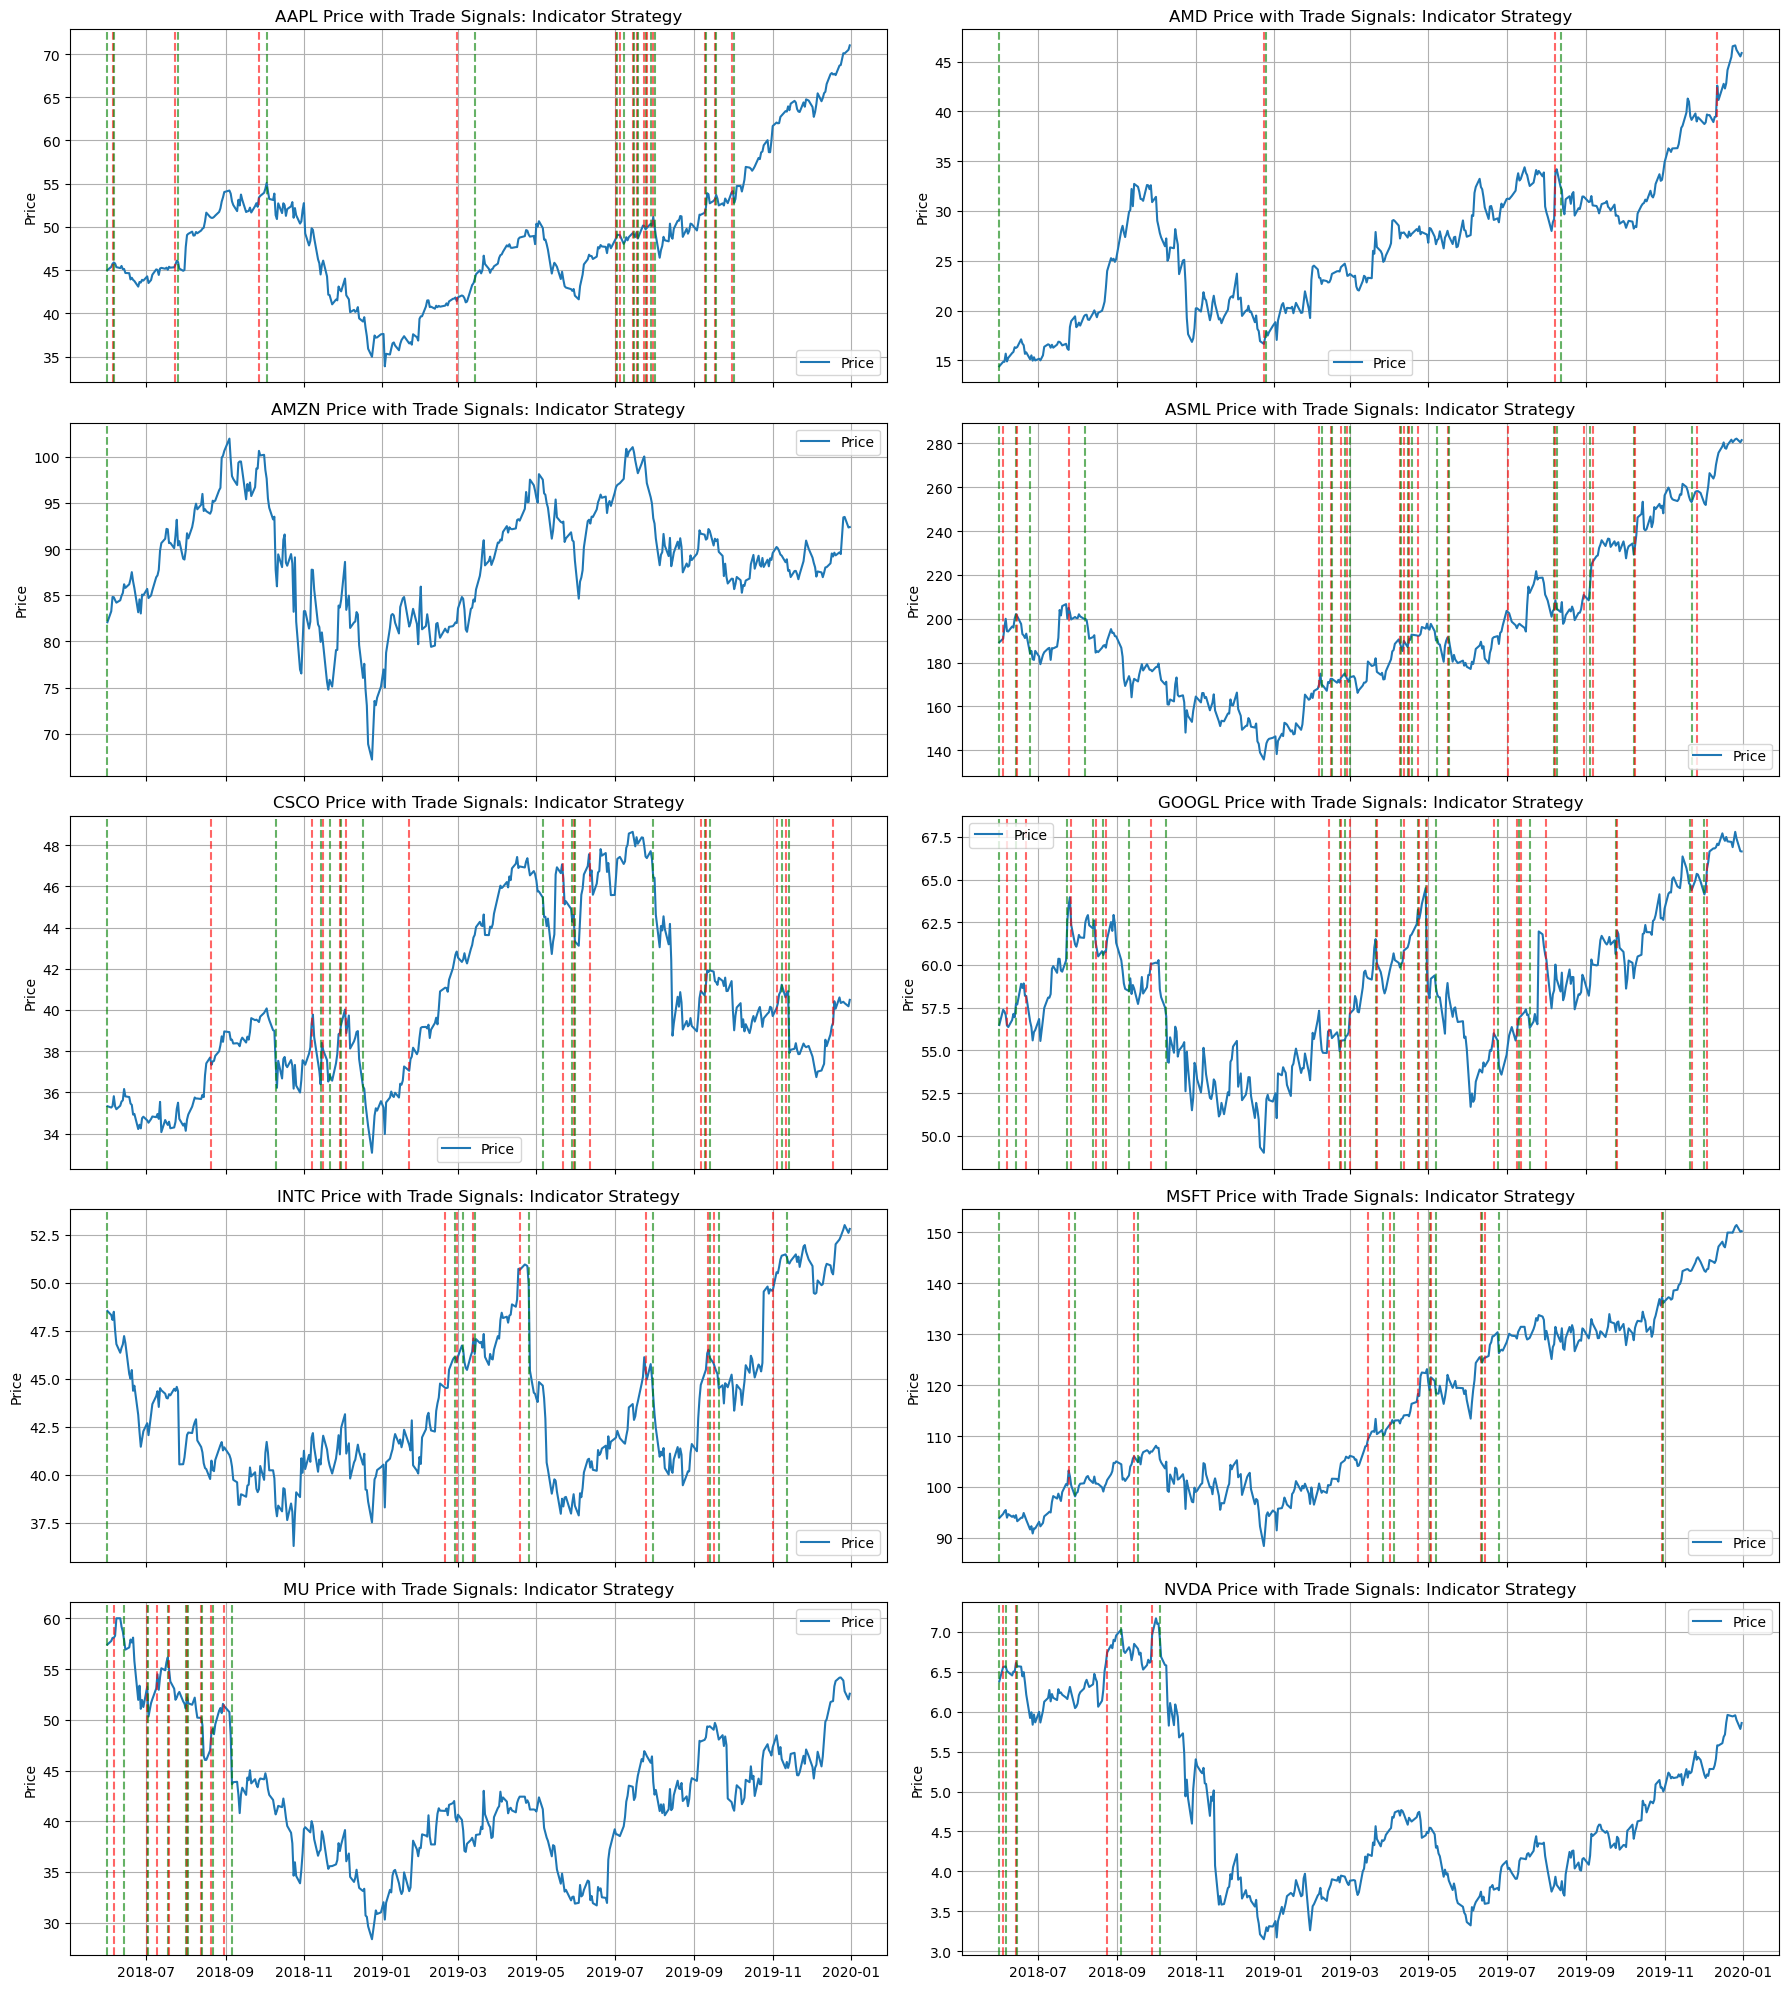

In [375]:
plot_all_trade_signals_grid(df_trades, price_matrix, "Indicator")

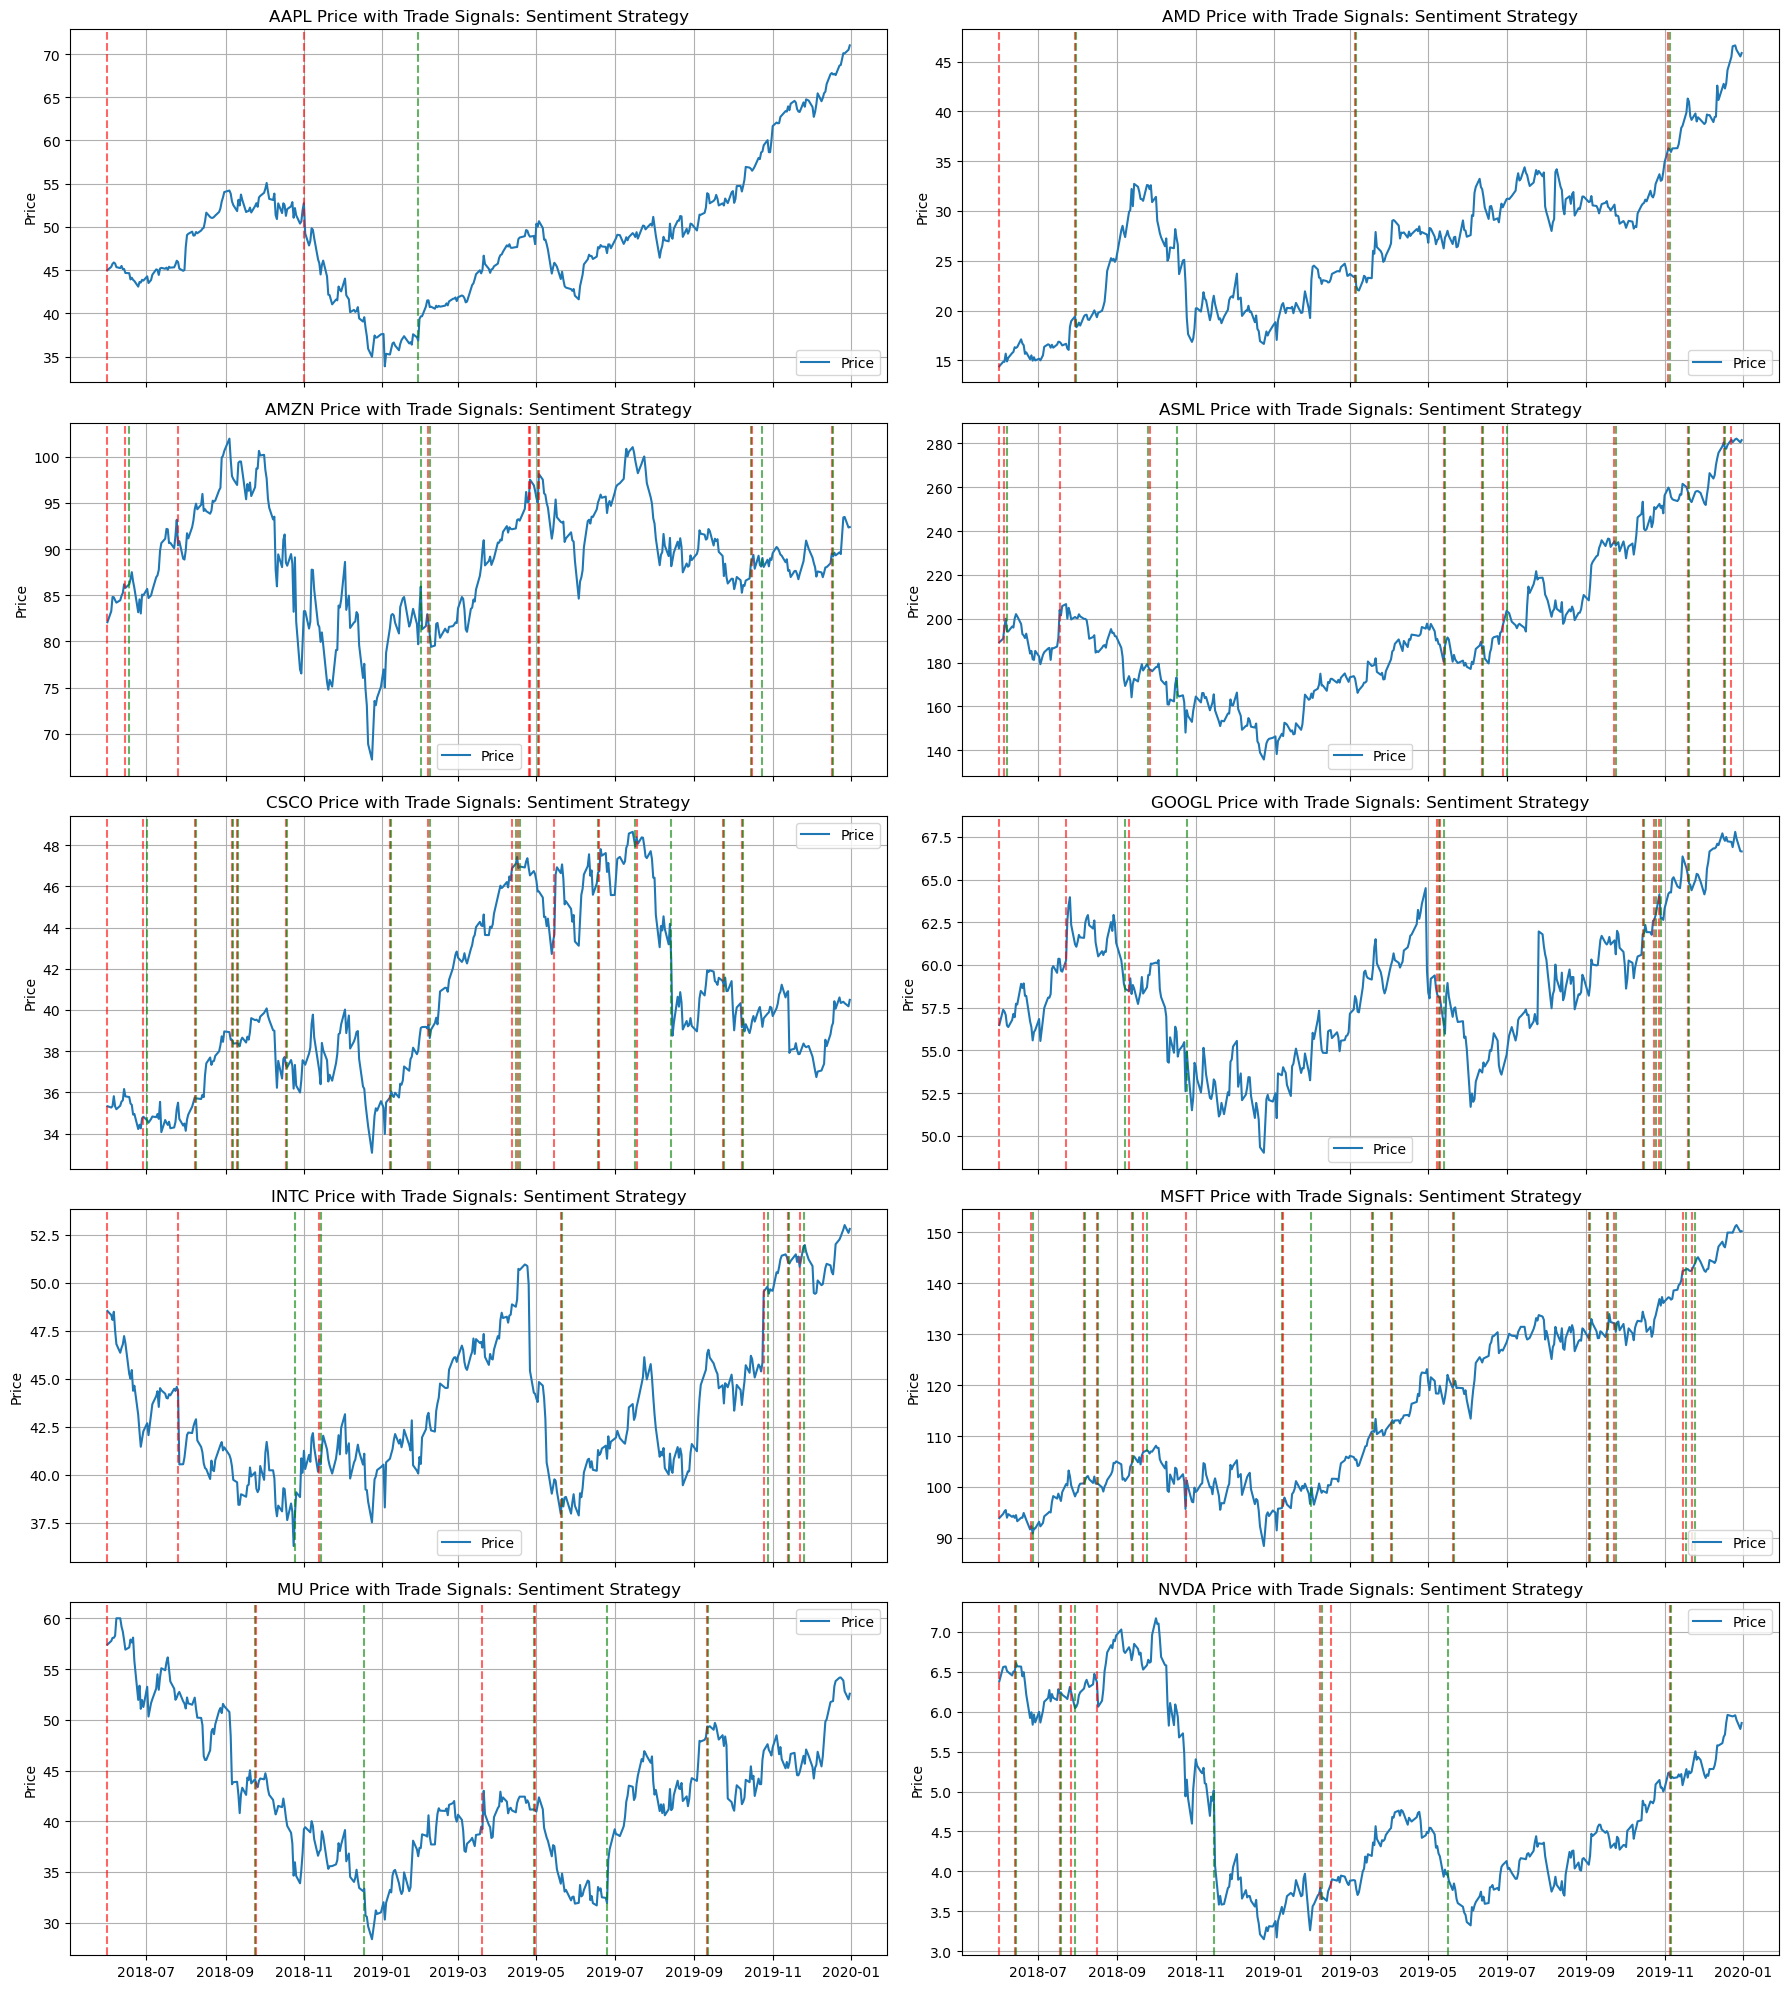

In [376]:
plot_all_trade_signals_grid(df_sentiment_trades, price_matrix, "Sentiment")